
ÂêÑÂàóÁº∫Â§±ÂÄºÁªüËÆ°Ôºö
nozzle_diameter    153
printing_speed     109
extrusion_speed     89
extrusion_temp      14
extruder_type       12
filament_aspect     10
platform_temp        8
dtype: int64
DataFrame Áª¥Â∫¶: (1172, 331)


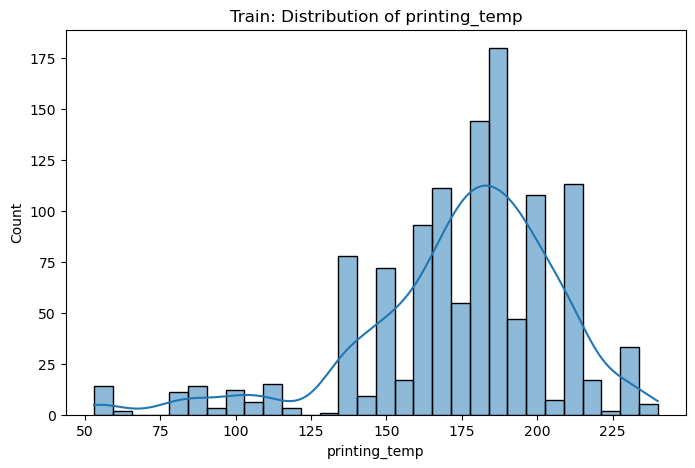

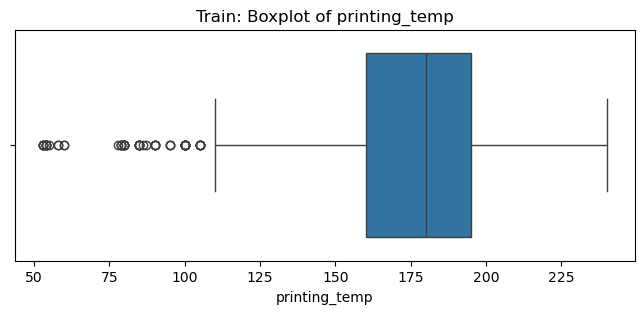

=== Target Descriptive Statistics ===
count    1172.000000
mean      174.903584
std        32.783990
min        53.000000
25%       160.000000
50%       180.000000
75%       195.000000
max       240.000000
Name: printing_temp, dtype: float64 

Skewness: -1.193
Kurtosis: 2.133


In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm import tqdm


# 1. ËØªÂèñÊï∞ÊçÆ
df = pd.read_excel(r"D:\ML-3DPrinting-Project\data\7.9_datasets\2_regression_original.xlsx")

# 2. Âà†Èô§‰∏çÈúÄË¶ÅÁöÑÂàó
#drop_cols = ['article']
#df = df.drop(columns=drop_cols)
 
# 3. ‰∏¢ÂºÉÈ´òÁº∫Â§±Âàó & ÁõÆÊ†áÁº∫Â§±Ë°å
df = df.dropna(axis=1, thresh=len(df)*0.5)
target_col = "printing_temp"
df = df.dropna(subset=[target_col]).reset_index(drop=True)

# 4.ÁªüËÆ°ÂêÑÂàóÁº∫Â§±ÂÄº
missing_counts = df.isnull().sum().sort_values(ascending=False)
print("\nÂêÑÂàóÁº∫Â§±ÂÄºÁªüËÆ°Ôºö")
print(missing_counts[missing_counts > 0])

# 5. Êü•ÁúãÁª¥Â∫¶
print(f"DataFrame Áª¥Â∫¶: {df.shape}")

# 1. ÂàíÂàÜ X, y
X = df.drop(columns=[target_col])
y = df[target_col]


# 2. Ê†áÁ≠æÂàÜÂ∏ÉÂèØËßÜÂåñ & ÁªüËÆ°
plt.figure(figsize=(8,5))
sns.histplot(y, bins=30, kde=True)
plt.title(f"Train: Distribution of {target_col}")
plt.show()

plt.figure(figsize=(8,3))
sns.boxplot(x=y)
plt.title(f"Train: Boxplot of {target_col}")
plt.show()

print("=== Target Descriptive Statistics ===")
print(y.describe(), "\n")
print(f"Skewness: {skew(y):.3f}")
print(f"Kurtosis: {kurtosis(y):.3f}")


In [2]:
# === Step 2: Êï∞ÊçÆÈõÜÂàíÂàÜÔºàÂú®‰ªª‰ΩïÁºñÁ†Å„ÄÅÊ†áÂáÜÂåñ‰πãÂâçÔºâ===
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Step 3: Ê∑ªÂä†Áº∫Â§±Ê†áÂøóÂàóÔºàÊï∞ÂÄºÂàóÔºâ===
def add_missing_flags(X_raw):
    num_cols = X_raw.select_dtypes(include=['float64', 'int64']).columns
    missing_flags = pd.DataFrame(index=X_raw.index)
    for col in num_cols:
        if X_raw[col].isna().sum() > 0:
            missing_flags[f'{col}_was_missing'] = X_raw[col].isna().astype(int)
    return pd.concat([X_raw, missing_flags], axis=1)

X_train_flagged = add_missing_flags(X_train_raw)
X_test_flagged = add_missing_flags(X_test_raw)

# === Step 4: Á±ªÂà´Â°´Ë°• + One-Hot ÁºñÁ†Å ===
cat_cols = X_train_flagged.select_dtypes(include=['object', 'category']).columns
X_train_flagged[cat_cols] = X_train_flagged[cat_cols].fillna("missing")
X_test_flagged[cat_cols] = X_test_flagged[cat_cols].fillna("missing")

X_train_encoded = pd.get_dummies(X_train_flagged, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_flagged, drop_first=True)

# ÂØπÈΩêÊµãËØïÈõÜÂàóÔºàÈÅøÂÖçÁº∫ÂàóÔºâ
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
cols = X_train_encoded.columns  # ËÆ∞ÂΩïÂàóÂêçÁî®‰∫é SHAP
# === Step 5: Ê†áÂáÜÂåñ ===
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded), columns=X_train_encoded.columns, index=X_train_encoded.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_encoded), columns=X_test_encoded.columns, index=X_test_encoded.index)

# === Step 6: Ëá™ÁõëÁù£ MLP Â°´Ë°•Áº∫Â§±ÂÄº ===
X_train_filled = X_train_scaled.copy()
X_test_filled = X_test_scaled.copy()
X_train_original = X_train_raw.copy()

num_cols = X_train_raw.select_dtypes(include=['float64', 'int64']).columns
filled_features = []

for col in tqdm(num_cols):
    if X_train_original[col].isna().sum() == 0:
        continue

    mask_train = X_train_original[col].isna()
    not_missing_mask = ~mask_train

    valid_cols = [c for c in X_train_scaled.columns if c != col and not X_train_scaled[c].isna().any()]
    if not valid_cols:
        continue

    X_train_feat = X_train_scaled.loc[not_missing_mask, valid_cols]
    y_train_feat = X_train_scaled.loc[not_missing_mask, col]

    model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
    model.fit(X_train_feat, y_train_feat)

    # Â°´Ë°•ËÆ≠ÁªÉÈõÜ
    X_missing_feat_train = X_train_scaled.loc[mask_train, valid_cols]
    X_train_filled.loc[mask_train, col] = model.predict(X_missing_feat_train)

    # Â°´Ë°•ÊµãËØïÈõÜÔºàÊ≥®ÊÑèÔºö‰ΩøÁî® train Ê®°ÂûãÔºâ
    mask_test = X_test_raw[col].isna() if col in X_test_raw.columns else None
    if mask_test is not None and mask_test.any():
        X_missing_feat_test = X_test_scaled.loc[mask_test, valid_cols]
        X_test_filled.loc[mask_test, col] = model.predict(X_missing_feat_test)

    filled_features.append(col)

print(f"Â∑≤ÊàêÂäüÂ°´Ë°•‰ª•‰∏ãÁâπÂæÅÁº∫Â§±: {filled_features}")

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 327/327 [00:03<00:00, 88.34it/s]

Â∑≤ÊàêÂäüÂ°´Ë°•‰ª•‰∏ãÁâπÂæÅÁº∫Â§±: ['extrusion_temp', 'extrusion_speed', 'printing_speed', 'platform_temp', 'nozzle_diameter']


Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


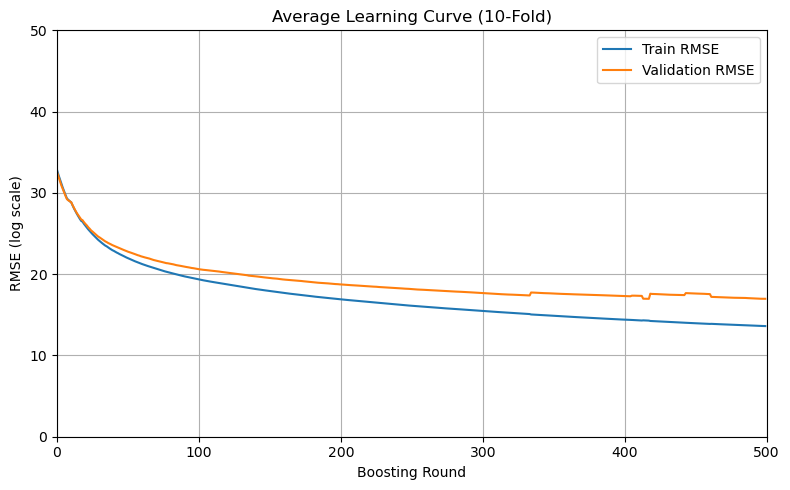


[Âπ≥ÂùáÂ≠¶‰π†Êõ≤Á∫ø] È™åËØÅÈõÜ RMSE ÊúÄÂ∞èËΩÆÊ¨° (ËøáÊãüÂêàÊãêÁÇπ)Ôºö417


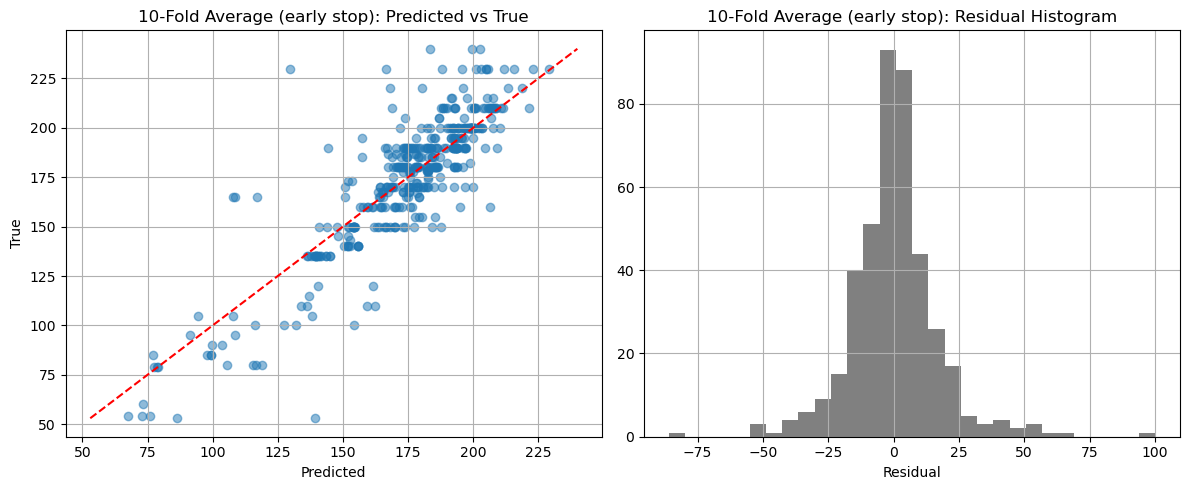


[‰∫§ÂèâÈ™åËØÅÂπ≥ÂùáËÆ≠ÁªÉÈõÜÊåáÊ†á] (early stop)
Train RMSE : 14.0717
Train MAE  : 10.1814
Train R¬≤   : 0.8184

[‰∫§ÂèâÈ™åËØÅÂπ≥ÂùáÈ™åËØÅÈõÜÊåáÊ†á] (early stop)
Val   RMSE : 16.6416
Val   MAE  : 11.8042
Val   R¬≤   : 0.7301

[ÊåáÊ†áÂ∑ÆÂÄº (Val - Train)]
RMSE Â∑ÆÂÄº : 2.5698
R¬≤   Â∑ÆÂÄº : -0.0884

[10ÊäòÊï¥‰ΩìÂπ≥ÂùáÊåáÊ†á] (early stop)
RMSE : 17.1163
MSE  : 292.9663
MAE  : 11.5087
R¬≤   : 0.7551

[Top50 SHAP ÁâπÂæÅÈ¢ëÁéáÁªüËÆ°]

[Top50 PCA ÁâπÂæÅÈ¢ëÁéáÁªüËÆ°]


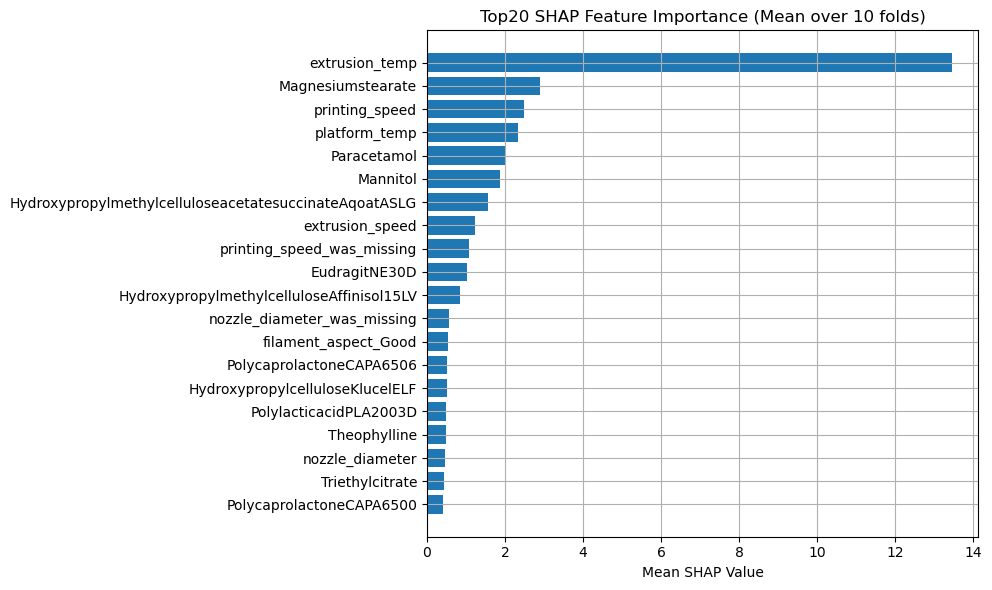

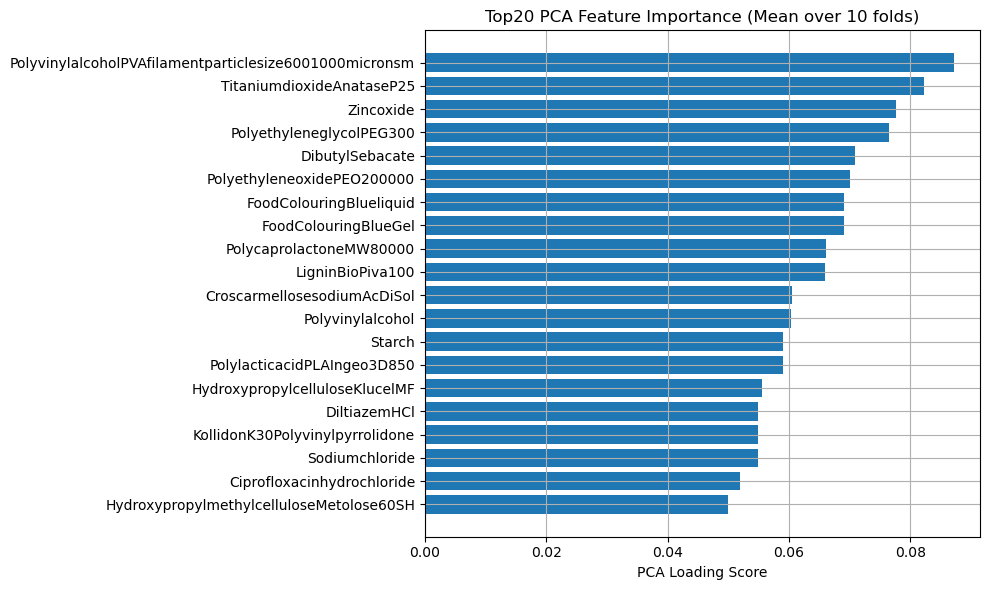

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import shap
from sklearn.decomposition import PCA
from collections import Counter

# ËØ∑ÊõøÊç¢‰∏∫‰Ω†ÁöÑÂèòÈáè
X = X_train_filled.copy()
y = y_train.copy()

kf = KFold(n_splits=10, shuffle=True, random_state=42)

train_rmse_list, val_rmse_list = [], []
train_r2_list, val_r2_list = [], []
train_mae_list, val_mae_list = [], []
evals_result_all = []
shap_features_all, pca_features_all = [], []
all_y_true, all_y_pred = [], []
feature_names = X.columns.tolist()
X_array, y_array = X.values, y.values

shap_score_dict = {}
pca_score_dict = {}  # ÊØèÊäò‰øùÂ≠ò PCA Âä†ËΩΩÈáè

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}/10")
    X_train_fold, X_val_fold = X_array[train_idx], X_array[val_idx]
    y_train_fold, y_val_fold = y_array[train_idx], y_array[val_idx]

    dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dval = xgb.DMatrix(X_val_fold, label=y_val_fold)

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': 0.05,
        'max_depth': 2,
        'reg_alpha': 5.0,
        'reg_lambda': 10.0,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 2.0,
        'seed': 42
    }
    
    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=[(dtrain, 'train'), (dval, 'validation')],
        early_stopping_rounds=10,
        evals_result=evals_result,
        verbose_eval=False
    )

    evals_result_all.append(evals_result)

    y_train_pred = model.predict(dtrain)
    y_val_pred = model.predict(dval)

    train_rmse_list.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))
    val_rmse_list.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))
    train_mae_list.append(mean_absolute_error(y_train_fold, y_train_pred))
    val_mae_list.append(mean_absolute_error(y_val_fold, y_val_pred))
    train_r2_list.append(r2_score(y_train_fold, y_train_pred))
    val_r2_list.append(r2_score(y_val_fold, y_val_pred))

    all_y_true.extend(y_val_fold)
    all_y_pred.extend(y_val_pred)

    # SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val_fold)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    
    # ÊääÊØè‰∏™ÁâπÂæÅÁöÑ shap ÂÄº‰øùÂ≠òÂú® shap_score_dict ‰∏≠ÔºàÁî®‰∫éÂêéÁª≠Ê±ÇÂπ≥ÂùáÔºâ
    for feat, shap_val in zip(feature_names, mean_abs_shap):
        if feat not in shap_score_dict:
            shap_score_dict[feat] = []
        shap_score_dict[feat].append(shap_val)

    # PCA
    # ÊØè‰∏ÄÊäòÂÜÖ PCA Âä†ËΩΩÈáè‰øùÂ≠ò
    pca = PCA(n_components=50)
    pca.fit(X_val_fold)
    
    # Ëé∑ÂèñÁ¨¨‰∏Ä‰∏™‰∏ªÊàêÂàÜÁöÑÁâπÂæÅË¥°ÁåÆ
    pca_loading = np.abs(pca.components_[0])
    
    # Â∞ÜÊØè‰∏™ÁâπÂæÅÁöÑË¥°ÁåÆÂä†ÂÖ•Â≠óÂÖ∏
    for feat, loading in zip(feature_names, pca_loading):
        if feat not in pca_score_dict:
            pca_score_dict[feat] = []
        pca_score_dict[feat].append(loading)


# Âπ≥ÂùáÂ≠¶‰π†Êõ≤Á∫ø
max_round = max([len(res['train']['rmse']) for res in evals_result_all])
train_rmse_curve = np.zeros(max_round)
val_rmse_curve = np.zeros(max_round)
count = np.zeros(max_round)

for res in evals_result_all:
    rounds = len(res['train']['rmse'])
    train_rmse_curve[:rounds] += res['train']['rmse']
    val_rmse_curve[:rounds] += res['validation']['rmse']
    count[:rounds] += 1

train_rmse_curve /= count
val_rmse_curve /= count

plt.figure(figsize=(8, 5))
plt.plot(train_rmse_curve, label='Train RMSE')
plt.plot(val_rmse_curve, label='Validation RMSE')
plt.ylim(0, 50)  # üëà Âõ∫ÂÆöÁ∫µËΩ¥ËåÉÂõ¥
plt.xlim(0, len(train_rmse_curve))
plt.xlabel('Boosting Round')
plt.ylabel('RMSE (log scale)')
plt.title('Average Learning Curve (10-Fold)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ÊâæÂà∞È™åËØÅÈõÜ RMSE ÊúÄÂ∞èÁöÑËΩÆÊ¨°ÔºàÂç≥ËøáÊãüÂêàÊãêÁÇπÔºâ
overfit_point = np.argmin(val_rmse_curve)
print(f"\n[Âπ≥ÂùáÂ≠¶‰π†Êõ≤Á∫ø] È™åËØÅÈõÜ RMSE ÊúÄÂ∞èËΩÆÊ¨° (ËøáÊãüÂêàÊãêÁÇπ)Ôºö{overfit_point}")

# Â∞ÜÈ¢ÑÊµã‰∏éÁúüÂÆûÂÄºÊà™Êñ≠‰∏∫ËøáÊãüÂêàËΩÆÊï∞Ââç
ally_true = np.array(all_y_true[:overfit_point+1])
ally_pred = np.array(all_y_pred[:overfit_point+1])
residuals = ally_true - ally_pred

# ----------- ÂèØËßÜÂåñÔºöÈ¢ÑÊµã vs ÁúüÂÆûÂÄºÔºåÊÆãÂ∑ÆÁõ¥ÊñπÂõæ ----------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(ally_pred, ally_true, alpha=0.5)
plt.plot([ally_true.min(), ally_true.max()], [ally_true.min(), ally_true.max()], 'r--')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('10-Fold Average (early stop): Predicted vs True')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, color='gray')
plt.xlabel('Residual')
plt.title('10-Fold Average (early stop): Residual Histogram')
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------- Âè™‰øùÁïôÂâçoverfitËΩÆÊï∞ÁöÑËÆ≠ÁªÉ/È™åËØÅÊåáÊ†á ----------
# ----------- Âè™‰øùÁïôÂà∞ overfit ËΩÆÊï∞ÁöÑËÆ≠ÁªÉ/È™åËØÅÊåáÊ†á ----------
print("\n[‰∫§ÂèâÈ™åËØÅÂπ≥ÂùáËÆ≠ÁªÉÈõÜÊåáÊ†á] (early stop)")
train_rmse = np.mean(train_rmse_list[:overfit_point+1])
train_mae = np.mean(train_mae_list[:overfit_point+1])
train_r2  = np.mean(train_r2_list[:overfit_point+1])
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Train MAE  : {train_mae:.4f}")
print(f"Train R¬≤   : {train_r2:.4f}")

print("\n[‰∫§ÂèâÈ™åËØÅÂπ≥ÂùáÈ™åËØÅÈõÜÊåáÊ†á] (early stop)")
val_rmse = np.mean(val_rmse_list[:overfit_point+1])
val_mae  = np.mean(val_mae_list[:overfit_point+1])
val_r2   = np.mean(val_r2_list[:overfit_point+1])
print(f"Val   RMSE : {val_rmse:.4f}")
print(f"Val   MAE  : {val_mae:.4f}")
print(f"Val   R¬≤   : {val_r2:.4f}")

# ----------- Â∑ÆÂÄºÈÉ®ÂàÜËæìÂá∫ ----------
print("\n[ÊåáÊ†áÂ∑ÆÂÄº (Val - Train)]")
print(f"RMSE Â∑ÆÂÄº : {val_rmse - train_rmse:.4f}")
print(f"R¬≤   Â∑ÆÂÄº : {val_r2 - train_r2:.4f}")

# ----------- ÊÄª‰ΩìÊåáÊ†áËØÑ‰º∞ (Âè™ÁªüËÆ°Âà∞Êó©ÂÅúËΩÆÊï∞) ----------
print("\n[10ÊäòÊï¥‰ΩìÂπ≥ÂùáÊåáÊ†á] (early stop)")
print(f"RMSE : {np.sqrt(mean_squared_error(ally_true, ally_pred)):.4f}")
print(f"MSE  : {mean_squared_error(ally_true, ally_pred):.4f}")
print(f"MAE  : {mean_absolute_error(ally_true, ally_pred):.4f}")
print(f"R¬≤   : {r2_score(ally_true, ally_pred):.4f}")

# ----------- ÁâπÂæÅÂá∫Áé∞È¢ëÁéáÁªüËÆ°‰øùÊåÅ‰∏çÂèò ----------
print("\n[Top50 SHAP ÁâπÂæÅÈ¢ëÁéáÁªüËÆ°]")
for feat, cnt in Counter(shap_features_all).most_common(50):
    print(f"{feat}: {cnt} folds")

print("\n[Top50 PCA ÁâπÂæÅÈ¢ëÁéáÁªüËÆ°]")
for feat, cnt in Counter(pca_features_all).most_common(50):
    print(f"{feat}: {cnt} folds")
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from collections import Counter

# ------------ SHAP Top50 & ÂèØËßÜÂåñ Top20 ------------
# ‰∫§ÂèâÈ™åËØÅÁªìÊùüÂêéÔºåËÆ°ÁÆóÊØè‰∏™ÁâπÂæÅÁöÑÂπ≥Âùá SHAP
shap_score_avg = {feat: np.mean(vals) for feat, vals in shap_score_dict.items()}

# ÊåâÂπ≥ÂùáÂÄºÊéíÂ∫èÔºå‰øùÁïô Top50 Âíå Top20
sorted_shap_avg = sorted(shap_score_avg.items(), key=lambda x: x[1], reverse=True)
shap_top50 = sorted_shap_avg[:50]
shap_top20 = sorted_shap_avg[:20]
shap_top_features = [feat for feat, _ in shap_top50]  # üëà Ë°•ËøôÂè•Âç≥ÂèØ

# ÂèØËßÜÂåñ Top20
top20_feats = [x[0] for x in shap_top20][::-1]
top20_scores = [x[1] for x in shap_top20][::-1]

plt.figure(figsize=(10, 6))
plt.barh(top20_feats, top20_scores)
plt.xlabel("Mean SHAP Value")
plt.title("Top20 SHAP Feature Importance (Mean over 10 folds)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------ PCA Top50 & ÂèØËßÜÂåñ Top20 ------------
# Ê±ÇÊØè‰∏™ÁâπÂæÅÂú®10Êäò‰∏≠ÁöÑÂπ≥ÂùáË¥°ÁåÆ
pca_score_avg = {feat: np.mean(scores) for feat, scores in pca_score_dict.items()}

# ÂèñÂπ≥ÂùáË¥°ÁåÆTop 50ÁöÑÁâπÂæÅ
pca_score_avg_sorted = sorted(pca_score_avg.items(), key=lambda x: x[1], reverse=True)
top50_pca = pca_score_avg_sorted[:50]
top20_pca = pca_score_avg_sorted[:20]

# ‰øùÂ≠òTop50ÁâπÂæÅÂêçÁß∞
pca_top_features = [feat for feat, _ in top50_pca]

# ÂèØËßÜÂåñ Top20 PCA Ë¥°ÁåÆ
plt.figure(figsize=(10, 6))
plt.barh([feat for feat, _ in reversed(top20_pca)],
         [score for _, score in reversed(top20_pca)])
plt.xlabel("PCA Loading Score")
plt.title("Top20 PCA Feature Importance (Mean over 10 folds)")
plt.grid(True)
plt.tight_layout()
plt.show()



In [4]:
from collections import Counter
from sklearn.preprocessing import StandardScaler

# ÁâπÂæÅÂπ∂ÈõÜÔºà‰∏çÂéª‰∫§ÈõÜÔºåÂè™Áî®‰∫éÊâìÂç∞Ôºâ
all_top_features = shap_top_features + pca_top_features
selected_features = list(set(all_top_features))  # ‚úÖ Âπ∂ÈõÜ

# ÊâìÂç∞‰∫§ÈõÜÔºå‰ªÖ‰æõÂèÇËÄÉ
feature_counter = Counter(all_top_features)
overlapped_features = [feat for feat, count in feature_counter.items() if count == 2]
print(f"üëÄ SHAPÂíåPCA‰∫§ÈõÜÁâπÂæÅÊï∞: {len(overlapped_features)}\n{overlapped_features}")
print(f"‚úÖ ÊúÄÁªàÁî®‰∫éÂª∫Ê®°ÁöÑÁâπÂæÅÊï∞ÔºàÂπ∂ÈõÜÔºâ: {len(selected_features)}")

# Ê†áÂáÜÂåñÁâπÂæÅ
X_selected = X_train_filled[selected_features]
feature_names = X_selected.columns

scaler = StandardScaler()
X_selected_scaled = pd.DataFrame(scaler.fit_transform(X_selected), columns=feature_names)

# ÊµãËØïÈõÜ‰πüÂáÜÂ§áÂ•Ω
X_test_selected = X_test_filled[selected_features]
X_test_scaled = scaler.transform(X_test_selected)

üëÄ SHAPÂíåPCA‰∫§ÈõÜÁâπÂæÅÊï∞: 17
['extrusion_temp', 'Magnesiumstearate', 'printing_speed', 'platform_temp', 'Paracetamol', 'Mannitol', 'extrusion_speed', 'printing_speed_was_missing', 'filament_aspect_Good', 'HydroxypropylcelluloseKlucelELF', 'extruder_type_twin-screw extruder', 'extruder_type_single-screw extruder', 'BenzoinOleogumresin', 'PolycaprolactoneMW80000', 'printability_yes', 'extrusion_speed_was_missing', 'filament_aspect_Flexible']
‚úÖ ÊúÄÁªàÁî®‰∫éÂª∫Ê®°ÁöÑÁâπÂæÅÊï∞ÔºàÂπ∂ÈõÜÔºâ: 83


Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


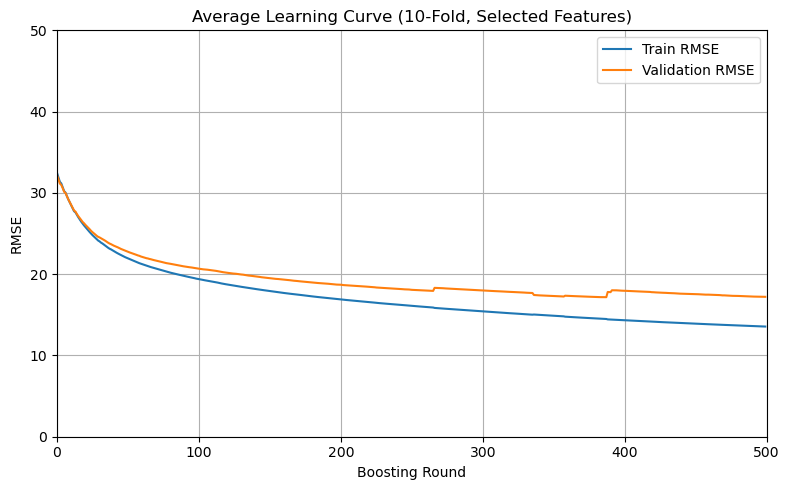


Âπ≥ÂùáÂ≠¶‰π†Êõ≤Á∫øÈ™åËØÅÈõÜ RMSE ÊúÄÂ∞èËΩÆÊï∞ÔºàËøáÊãüÂêàÂàÜÁÇπÔºâ: 387


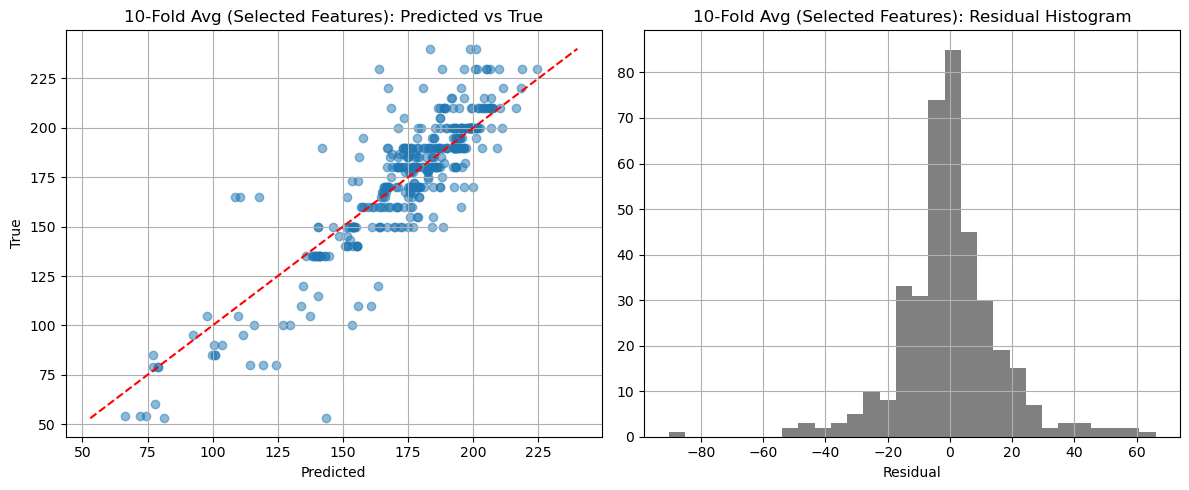


üìå‰∫§ÂèâÈ™åËØÅÂπ≥ÂùáÊåáÊ†áÔºàearly stopÔºâ
Train RMSE : 14.2888
Train MAE  : 10.3174
Train R¬≤   : 0.8126
Val   RMSE : 16.6508
Val   MAE  : 11.7778
Val   R¬≤   : 0.7287

üìâ RMSE Â∑ÆÂÄº: 2.3621
üìâ R¬≤   Â∑ÆÂÄº: -0.0839


In [5]:
# Êõø‰ª£ x = X_train_filled.copy()
x_selected = X_train_filled[selected_features].copy()
y_selected = y_train.copy()

kf_selected = KFold(n_splits=10, shuffle=True, random_state=42)

# ÂàùÂßãÂåñÂÆπÂô®
train_rmse_list_sel, val_rmse_list_sel = [], []
train_mae_list_sel, val_mae_list_sel = [], []
train_r2_list_sel, val_r2_list_sel = [], []
evals_result_all_sel = []
all_y_true_sel, all_y_pred_sel = [], []

X_array_sel, y_array_sel = x_selected.values, y_selected.values
feature_names_sel = x_selected.columns.tolist()

for fold, (train_idx, val_idx) in enumerate(kf_selected.split(x_selected)):
    print(f"Fold {fold+1}/10")
    
    X_train_fold, X_val_fold = X_array_sel[train_idx], X_array_sel[val_idx]
    y_train_fold, y_val_fold = y_array_sel[train_idx], y_array_sel[val_idx]

    dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dval = xgb.DMatrix(X_val_fold, label=y_val_fold)

    # Ê®°ÂûãÂèÇÊï∞
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': 0.05,
        'max_depth': 2,
        'reg_alpha': 5.0,
        'reg_lambda': 10.0,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 2.0,
        'seed': 42
    }
    evals_result = {}
    model = xgb.train(params, dtrain, num_boost_round=500,
                      evals=[(dtrain, 'train'), (dval, 'validation')],
                      early_stopping_rounds=10,
                      evals_result=evals_result,
                      verbose_eval=False)
    
    evals_result_all_sel.append(evals_result)

    # È¢ÑÊµã‰∏éÊâìÂàÜ
    y_train_pred = model.predict(dtrain)
    y_val_pred = model.predict(dval)

    train_rmse_list_sel.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))
    val_rmse_list_sel.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))
    train_mae_list_sel.append(mean_absolute_error(y_train_fold, y_train_pred))
    val_mae_list_sel.append(mean_absolute_error(y_val_fold, y_val_pred))
    train_r2_list_sel.append(r2_score(y_train_fold, y_train_pred))
    val_r2_list_sel.append(r2_score(y_val_fold, y_val_pred))

    all_y_true_sel.extend(y_val_fold)
    all_y_pred_sel.extend(y_val_pred)

# ÁîªÂπ≥ÂùáÂ≠¶‰π†Êõ≤Á∫ø
max_round = max([len(res['train']['rmse']) for res in evals_result_all_sel])
train_rmse_curve = np.zeros(max_round)
val_rmse_curve = np.zeros(max_round)
count = np.zeros(max_round)

for res in evals_result_all_sel:
    rounds = len(res['train']['rmse'])
    train_rmse_curve[:rounds] += res['train']['rmse']
    val_rmse_curve[:rounds] += res['validation']['rmse']
    count[:rounds] += 1

train_rmse_curve /= count
val_rmse_curve /= count

plt.figure(figsize=(8, 5))
plt.plot(train_rmse_curve, label='Train RMSE')
plt.plot(val_rmse_curve, label='Validation RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('Average Learning Curve (10-Fold, Selected Features)')
plt.ylim(0, 50)  # üëà Âõ∫ÂÆöÁ∫µËΩ¥ËåÉÂõ¥
plt.xlim([0, len(train_rmse_curve)])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ÊâæËøáÊãüÂêàÊãêÁÇπ
overfit_point_sel = np.argmin(val_rmse_curve)
print(f"\nÂπ≥ÂùáÂ≠¶‰π†Êõ≤Á∫øÈ™åËØÅÈõÜ RMSE ÊúÄÂ∞èËΩÆÊï∞ÔºàËøáÊãüÂêàÂàÜÁÇπÔºâ: {overfit_point_sel}")

# ÂèØËßÜÂåñÈ¢ÑÊµã vs ÂÆûÈôÖ
ally_true_sel = np.array(all_y_true_sel[:overfit_point_sel+1])
ally_pred_sel = np.array(all_y_pred_sel[:overfit_point_sel+1])
residuals_sel = ally_true_sel - ally_pred_sel

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(ally_pred_sel, ally_true_sel, alpha=0.5)
plt.plot([ally_true_sel.min(), ally_true_sel.max()], [ally_true_sel.min(), ally_true_sel.max()], 'r--')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("10-Fold Avg (Selected Features): Predicted vs True")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(residuals_sel, bins=30, color='gray')
plt.xlabel("Residual")
plt.title("10-Fold Avg (Selected Features): Residual Histogram")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nüìå‰∫§ÂèâÈ™åËØÅÂπ≥ÂùáÊåáÊ†áÔºàearly stopÔºâ")
train_rmse_sel = np.mean(train_rmse_list_sel[:overfit_point_sel+1])
train_mae_sel = np.mean(train_mae_list_sel[:overfit_point_sel+1])
train_r2_sel = np.mean(train_r2_list_sel[:overfit_point_sel+1])
val_rmse_sel = np.mean(val_rmse_list_sel[:overfit_point_sel+1])
val_mae_sel = np.mean(val_mae_list_sel[:overfit_point_sel+1])
val_r2_sel = np.mean(val_r2_list_sel[:overfit_point_sel+1])

print(f"Train RMSE : {train_rmse_sel:.4f}")
print(f"Train MAE  : {train_mae_sel:.4f}")
print(f"Train R¬≤   : {train_r2_sel:.4f}")
print(f"Val   RMSE : {val_rmse_sel:.4f}")
print(f"Val   MAE  : {val_mae_sel:.4f}")
print(f"Val   R¬≤   : {val_r2_sel:.4f}")
print(f"\nüìâ RMSE Â∑ÆÂÄº: {val_rmse_sel - train_rmse_sel:.4f}")
print(f"üìâ R¬≤   Â∑ÆÂÄº: {val_r2_sel - train_r2_sel:.4f}")



‚úÖ GridSearchCV 10-Fold Âπ≥ÂùáÊåáÊ†áÔºàÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêà idx=31ÔºâÔºö
RMSE: Train=5.1485 | Val=11.8579 ¬± 1.5406 | Gap=-6.7094
 MAE: Train=3.4314 | Val=7.3288 ¬± 0.6819 | Gap=-3.8974
 R¬≤:  Train=0.9757 | Val=0.8654 ¬± 0.0326 | Gap=0.1103


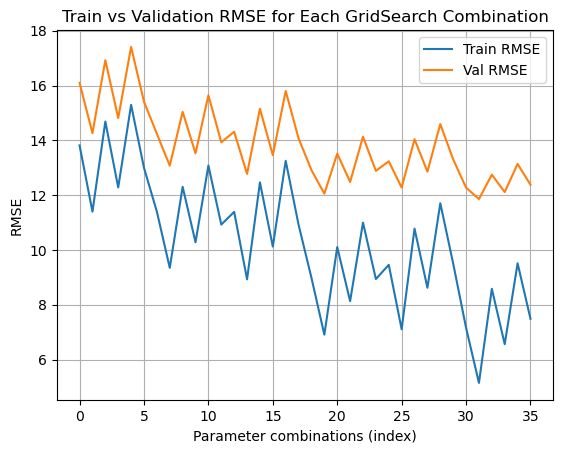

‚úÖ ÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêàÔºö {'depth': 8, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.05}

üìó ÊµãËØïÈõÜËØÑ‰º∞ÁªìÊûúÔºö
RMSE: 10.9145
MSE:  119.1272
MAE:  6.7893
R¬≤:   0.8812


In [6]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1Ô∏è‚É£ ÂÆö‰πâÊ®°Âûã
cat = CatBoostRegressor(random_state=42, verbose=0)  # ÂÖ≥Èó≠ËÆ≠ÁªÉËøáÁ®ãËæìÂá∫

# 2Ô∏è‚É£ ËÆæÁΩÆÊõ¥ÁªÜËá¥ÁöÑÂèÇÊï∞ÊêúÁ¥¢ËåÉÂõ¥
param_grid = {
    'iterations': [300, 500],
    'learning_rate': [0.03, 0.05],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

# 3Ô∏è‚É£ GridSearchCV ËÆæÁΩÆ
grid_search = GridSearchCV(
    estimator=cat,
    param_grid=param_grid,
    cv=10,
    scoring={
        'rmse': 'neg_root_mean_squared_error',
        'mae': 'neg_mean_absolute_error',
        'r2': 'r2'
    },
    refit='rmse',
    return_train_score=True,  # ‚Üê ÊîπËøôÈáåÔºÅ
    n_jobs=-1
)


# 4Ô∏è‚É£ ÊâßË°åÊêúÁ¥¢
grid_search.fit(X_selected_scaled, y_train)

cv_results = grid_search.cv_results_
idx = grid_search.best_index_

train_rmse = -cv_results['mean_train_rmse'][idx]
val_rmse = -cv_results['mean_test_rmse'][idx]
gap_rmse = train_rmse - val_rmse
std_rmse = cv_results['std_test_rmse'][idx]

train_r2 = cv_results['mean_train_r2'][idx]
val_r2 = cv_results['mean_test_r2'][idx]
gap_r2 = train_r2 - val_r2
std_r2 = cv_results['std_test_r2'][idx]

train_mae = -cv_results['mean_train_mae'][idx]
val_mae = -cv_results['mean_test_mae'][idx]
gap_mae = train_mae - val_mae
std_mae = cv_results['std_test_mae'][idx]


print(f"\n‚úÖ GridSearchCV 10-Fold Âπ≥ÂùáÊåáÊ†áÔºàÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêà idx={idx}ÔºâÔºö")
print(f"RMSE: Train={train_rmse:.4f} | Val={val_rmse:.4f} ¬± {std_rmse:.4f} | Gap={gap_rmse:.4f}")
print(f" MAE: Train={train_mae:.4f} | Val={val_mae:.4f} ¬± {std_mae:.4f} | Gap={gap_mae:.4f}")
print(f" R¬≤:  Train={train_r2:.4f} | Val={val_r2:.4f} ¬± {std_r2:.4f} | Gap={gap_r2:.4f}")

import matplotlib.pyplot as plt

rmse_train = -cv_results['mean_train_rmse']
rmse_val = -cv_results['mean_test_rmse']

plt.plot(rmse_train, label='Train RMSE')
plt.plot(rmse_val, label='Val RMSE')
plt.xlabel('Parameter combinations (index)')
plt.ylabel('RMSE')
plt.legend()
plt.title("Train vs Validation RMSE for Each GridSearch Combination")
plt.grid(True)
plt.show()
# 5Ô∏è‚É£ Ëé∑ÂèñÊúÄ‰Ω≥Ê®°Âûã‰∏éÂèÇÊï∞
best_cat = grid_search.best_estimator_
best_params = grid_search.best_params_
print("‚úÖ ÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêàÔºö", best_params)

# 7Ô∏è‚É£ Âú®ÂÖ®ËÆ≠ÁªÉÈõÜÊãüÂêàÊ®°ÂûãÂπ∂È¢ÑÊµãÊµãËØïÈõÜ
best_cat.fit(X_selected_scaled, y_train)  # ÂèØÈÄâ verbose=0
y_pred = best_cat.predict(X_test_scaled)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("\nüìó ÊµãËØïÈõÜËØÑ‰º∞ÁªìÊûúÔºö")
print(f"RMSE: {test_rmse:.4f}")
print(f"MSE:  {test_mse:.4f}")
print(f"MAE:  {test_mae:.4f}")
print(f"R¬≤:   {test_r2:.4f}")



üìä GridSearchCVÔºàÂä†Âº∫Ê≠£ÂàôÂåñÔºâ10-Fold Âπ≥ÂùáÊåáÊ†áÔºàÊúÄ‰Ω≥ÂèÇÊï∞ idx=18ÔºâÔºö
RMSE: Train=11.0789 | Val=14.1579 ¬± 1.8709 | Gap=-3.0790
 MAE: Train=8.1710 | Val=10.0010 ¬± 1.2578 | Gap=-1.8299
 R¬≤:  Train=0.8875 | Val=0.8064 ¬± 0.0579 | Gap=0.0811


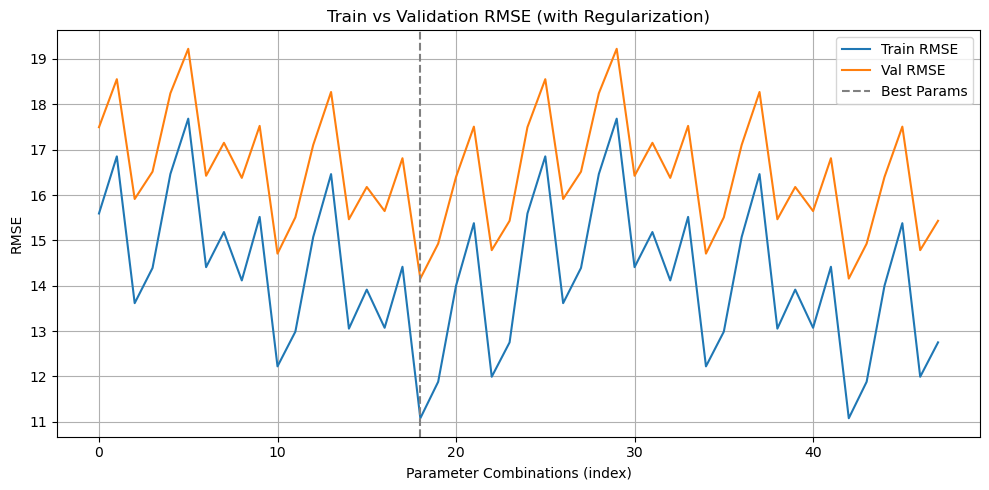

In [7]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

# ‚úÖ ÂÆö‰πâÊ®°Âûã
cat = CatBoostRegressor(verbose=0, random_state=42)

# ‚úÖ Âä†Âº∫Ê≠£ÂàôÂåñÂèÇÊï∞Á©∫Èó¥Ôºàdepth ‚ÜìÔºål2 ‚ÜëÔºâ
param_grid_regularized = {
    'iterations': [500],
    'learning_rate': [0.03, 0.05],
    'depth': [3, 4, 5],
    'l2_leaf_reg': [10, 15],
    'bagging_temperature': [0.5, 1.0],
    'random_strength': [1, 10],
}



# ‚úÖ ÊâßË°å GridSearchCV
grid_search = GridSearchCV(
    estimator=cat,
    param_grid=param_grid_regularized,
    cv=10,
    scoring={
        'rmse': 'neg_root_mean_squared_error',
        'mae': 'neg_mean_absolute_error',
        'r2': 'r2'
    },
    refit='rmse',
    return_train_score=True,
    n_jobs=-1
)

grid_search.fit(X_selected_scaled, y_train)

# ‚úÖ ÊèêÂèñÁªìÊûú
cv_results = grid_search.cv_results_
idx = grid_search.best_index_

# ÊåáÊ†áÊèêÂèñÔºàÂùáÂÄº + Ê†áÂáÜÂ∑Æ + gapÔºâ
train_rmse = -cv_results['mean_train_rmse'][idx]
val_rmse = -cv_results['mean_test_rmse'][idx]
gap_rmse = train_rmse - val_rmse
std_rmse = cv_results['std_test_rmse'][idx]

train_r2 = cv_results['mean_train_r2'][idx]
val_r2 = cv_results['mean_test_r2'][idx]
gap_r2 = train_r2 - val_r2
std_r2 = cv_results['std_test_r2'][idx]

train_mae = -cv_results['mean_train_mae'][idx]
val_mae = -cv_results['mean_test_mae'][idx]
gap_mae = train_mae - val_mae
std_mae = cv_results['std_test_mae'][idx]

# ‚úÖ ÊâìÂç∞ÂÆåÊï¥ÊåáÊ†áÊä•Âëä
print(f"\nüìä GridSearchCVÔºàÂä†Âº∫Ê≠£ÂàôÂåñÔºâ10-Fold Âπ≥ÂùáÊåáÊ†áÔºàÊúÄ‰Ω≥ÂèÇÊï∞ idx={idx}ÔºâÔºö")
print(f"RMSE: Train={train_rmse:.4f} | Val={val_rmse:.4f} ¬± {std_rmse:.4f} | Gap={gap_rmse:.4f}")
print(f" MAE: Train={train_mae:.4f} | Val={val_mae:.4f} ¬± {std_mae:.4f} | Gap={gap_mae:.4f}")
print(f" R¬≤:  Train={train_r2:.4f} | Val={val_r2:.4f} ¬± {std_r2:.4f} | Gap={gap_r2:.4f}")

# ‚úÖ ÂèØËßÜÂåñÔºöÂêÑÂèÇÊï∞ÁªÑÂêà‰∏ãÁöÑ RMSE Â≠¶‰π†Êõ≤Á∫ø
rmse_train_all = -cv_results['mean_train_rmse']
rmse_val_all = -cv_results['mean_test_rmse']

plt.figure(figsize=(10, 5))
plt.plot(rmse_train_all, label='Train RMSE')
plt.plot(rmse_val_all, label='Val RMSE')
plt.axvline(x=idx, color='gray', linestyle='--', label='Best Params')
plt.xlabel("Parameter Combinations (index)")
plt.ylabel("RMSE")
plt.title("Train vs Validation RMSE (with Regularization)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
print("ÂΩìÂâçÊ≠£ÂàôÂåñÊ®°ÂûãÁöÑÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêà‰∏∫Ôºö", grid_search.best_params_)


ÂΩìÂâçÊ≠£ÂàôÂåñÊ®°ÂûãÁöÑÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêà‰∏∫Ôºö {'bagging_temperature': 0.5, 'depth': 5, 'iterations': 500, 'l2_leaf_reg': 10, 'learning_rate': 0.05, 'random_strength': 1}


In [9]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# ÂÆö‰πâÊúÄ‰Ω≥ÂèÇÊï∞Ê®°Âûã
# ‚úÖ Ëá™Âä®‰ΩøÁî® GridSearch ÂæóÂà∞ÁöÑÊúÄ‰Ω≥ÂèÇÊï∞ÊûÑÂª∫Ê®°Âûã
best_params = grid_search.best_params_
best_cat = CatBoostRegressor(**best_params, verbose=0, random_state=42)

# ËÆ≠ÁªÉÊ®°Âûã
best_cat.fit(X_selected_scaled, y_train)

# ÊµãËØïÈõÜÈ¢ÑÊµã
y_pred_test = best_cat.predict(X_test_scaled)

# ÊµãËØïÈõÜÊåáÊ†áËØÑ‰º∞
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred)

print(f"üìä Test Set Evaluation with Best CatBoost Model:")
print(f"‚úÖ RMSE: {rmse_test:.4f}")
print(f"‚úÖ MSE:  {mse_test:.4f}")
print(f"‚úÖ MAE : {mae_test:.4f}")
print(f"‚úÖ R¬≤  : {r2_test:.4f}")


üìä Test Set Evaluation with Best CatBoost Model:
‚úÖ RMSE: 10.9145
‚úÖ MSE:  119.1272
‚úÖ MAE : 9.2966
‚úÖ R¬≤  : 0.8367


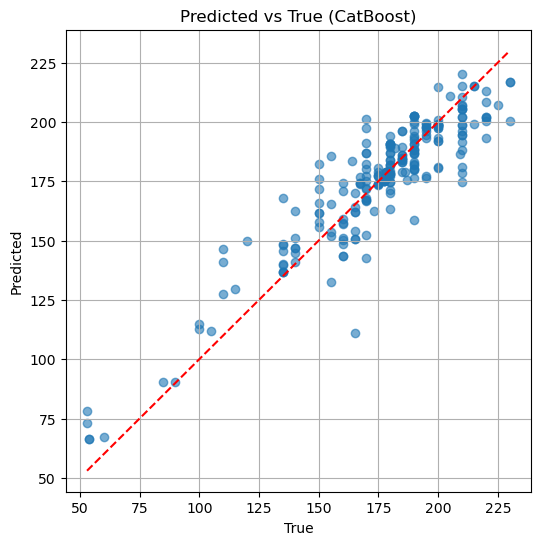

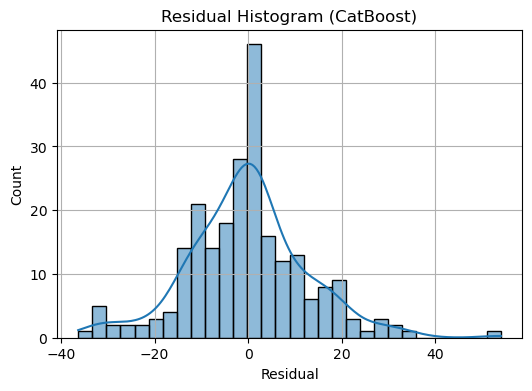

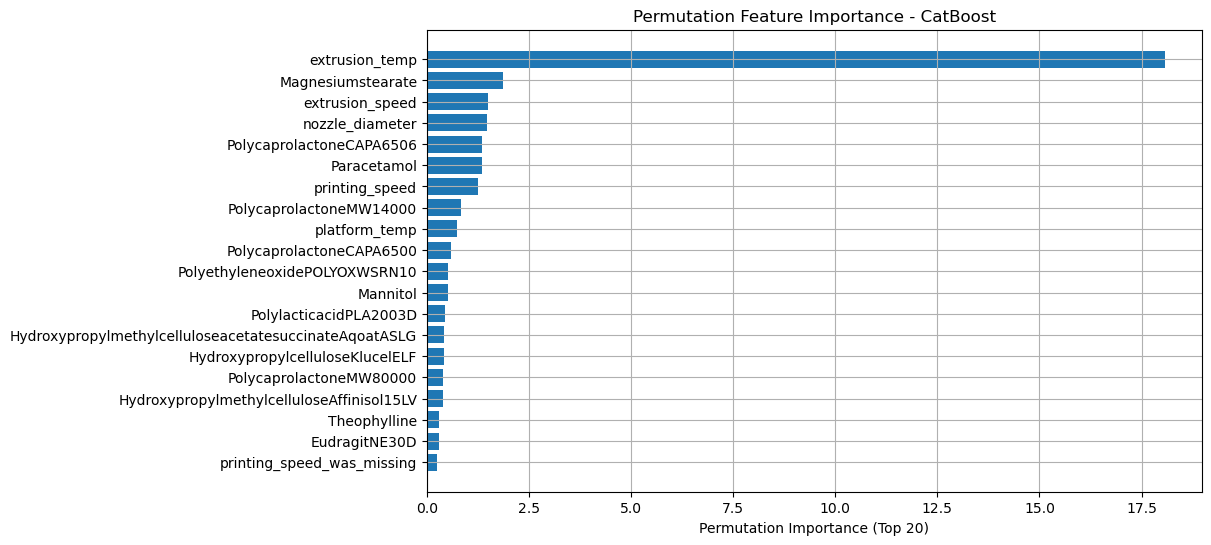

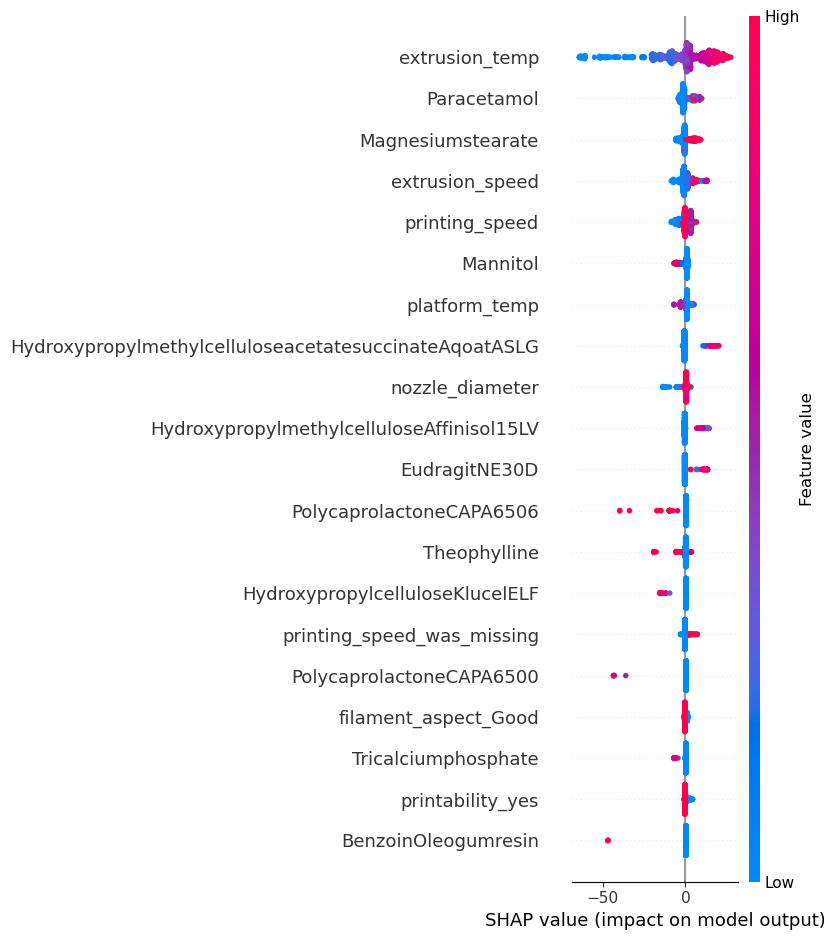

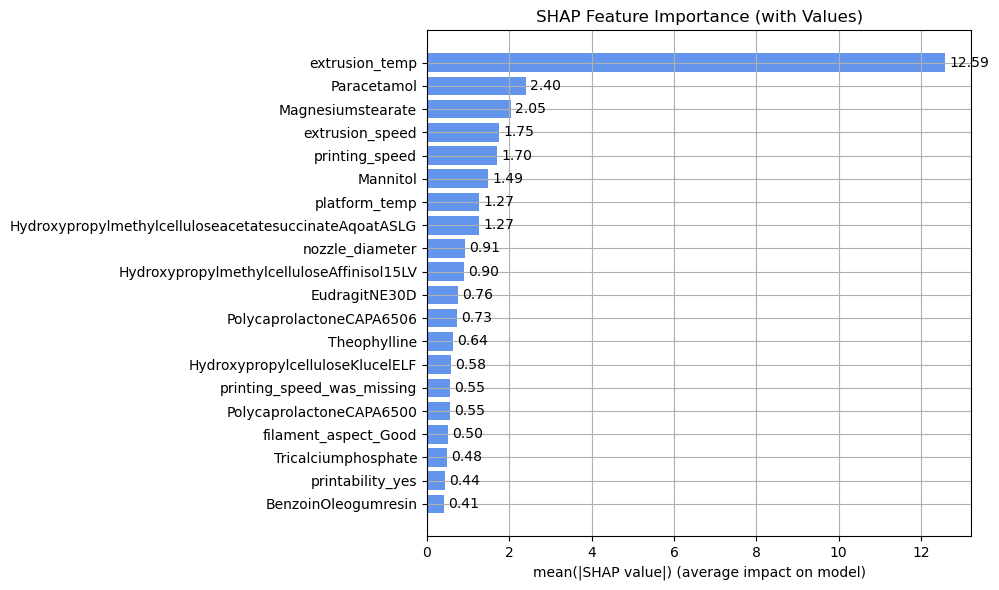

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# È¢ÑÊµãÊÆãÂ∑ÆÂèØËßÜÂåñ
residuals = y_test - y_pred_test

# È¢ÑÊµãÂÄº vs ÂÆûÈôÖÂÄºÊï£ÁÇπÂõæ
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Predicted vs True (CatBoost)")
plt.grid(True)
plt.show()

# ÊÆãÂ∑ÆÁõ¥ÊñπÂõæ
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residual")
plt.title("Residual Histogram (CatBoost)")
plt.grid(True)
plt.show()

# Permutation ÁâπÂæÅÈáçË¶ÅÊÄßÔºàTop 20Ôºâ
from sklearn.inspection import permutation_importance
result = permutation_importance(best_cat, X_test_scaled, y_test, n_repeats=30,
                                 random_state=42, scoring='neg_root_mean_squared_error')
sorted_idx = result.importances_mean.argsort()[::-1][:20]

plt.figure(figsize=(10, 6))
plt.barh(np.array(X_selected_scaled.columns)[sorted_idx],
         result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance (Top 20)")
plt.gca().invert_yaxis()
plt.title("Permutation Feature Importance - CatBoost")
plt.grid(True)
plt.show()

# SHAP ÂàÜÊûê
import shap
explainer = shap.TreeExplainer(best_cat)
shap_values = explainer.shap_values(X_selected_scaled)

# SHAP summary ÁÇπÂõæ
shap.summary_plot(shap_values, X_selected_scaled, max_display=20)

# SHAP bar ÂõæÔºàÊåâÂπ≥ÂùáÁªùÂØπÂÄºÔºâ
# ËÆ°ÁÆó mean(|SHAP value|) Âπ∂ÊéíÂ∫è
shap_values_mean = np.abs(shap_values).mean(axis=0)
sorted_idx = np.argsort(shap_values_mean)[::-1][:20]  # ÂèñÂâç20ÈáçË¶ÅÁâπÂæÅ

# Ëé∑ÂèñÁâπÂæÅÂêçÁß∞
feature_names = X_selected_scaled.columns

# ÁîªÂõæ
plt.figure(figsize=(10, 6))
bars = plt.barh(
    y=np.array(feature_names)[sorted_idx],
    width=shap_values_mean[sorted_idx],
    color='cornflowerblue'
)
plt.xlabel("mean(|SHAP value|) (average impact on model)")
plt.title("SHAP Feature Importance (with Values)")
plt.gca().invert_yaxis()
plt.grid(True)

# ÁªôÊØè‰∏™Êù°ÂΩ¢Ê∑ªÂä†Êï∞ÂÄºÊ†áÁ≠æ
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}", va='center')

plt.tight_layout()
plt.show()




üìä GridSearchCV 10-Fold Âπ≥ÂùáÊåáÊ†áÔºàÊúÄ‰ºòÂèÇÊï∞ÁªÑÂêà idx=113ÔºâÔºö
RMSE: Train=18.3122 | Val=20.1969 ¬± 1.8123 | Gap=-1.8847
MAE : Train=13.9870 | Val=15.1014 ¬± 0.8925 | Gap=-1.1144
R¬≤  : Train=0.6926 | Val=0.6125 ¬± 0.0498 | Gap=0.0801


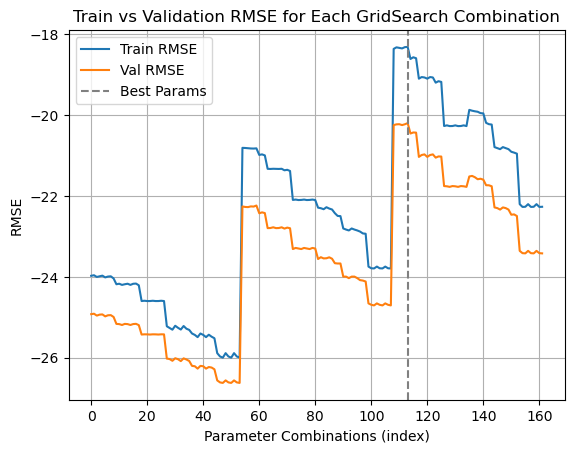

‚úÖ ÂΩìÂâç RF Ê®°ÂûãÁöÑÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêà‰∏∫Ôºö {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}

üìó ÊµãËØïÈõÜËØÑ‰º∞ÁªìÊûúÔºö
RMSE: 18.0362
MSE:  325.3038
MAE:  13.1321
R¬≤:   0.6755


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1Ô∏è‚É£ ÂÆö‰πâÊ®°Âûã‰∏éÂèÇÊï∞ÁΩëÊ†º
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [300, 400, 500],            # ÂæÆË∞ÉÊèêÂçáÊ®°ÂûãÂÆπÈáè
    'max_depth': [4, 6, 8],            # Êõ¥ÁªÜÁ≤íÂ∫¶ÁöÑÊ†ëÊ∑±Â∫¶Ë∞ÉÊéß
    'min_samples_leaf': [2, 3, 5],              # ÊéßÂà∂ÊØèÁâáÂè∂Â≠êÊúÄÂ∞èÊ†∑Êú¨Êï∞ÔºåÂΩ±ÂìçÊ®°ÂûãÂ§çÊùÇÂ∫¶
    'min_samples_split': [2, 5, 10],            # Âä†ÂÖ•Êñ∞ÂèÇÊï∞ÔºöÊØèÊ¨°ÂàÜË£ÇÊâÄÈúÄÊúÄÂ∞èÊ†∑Êú¨
    'max_features': ['sqrt', 'log2']            # ÊéßÂà∂ÊØèÊ£µÊ†ëÈÄâÊã©ÁâπÂæÅÊï∞ÈáèÁ≠ñÁï•
}

# 3. GridSearchCVÔºà‰∏é CatBoost ‰øùÊåÅ‰∏ÄËá¥ËÆæÁΩÆÔºâ
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=10,
    scoring={
        'rmse': 'neg_root_mean_squared_error',
        'mae': 'neg_mean_absolute_error',
        'r2': 'r2'
    },
    refit='rmse',
    return_train_score=True,
    n_jobs=-1
)

# 4. Ê®°ÂûãËÆ≠ÁªÉ
grid_search.fit(X_selected_scaled, y_train)

# 5. ÊèêÂèñ‰∫§ÂèâÈ™åËØÅÁªìÊûú
cv_results = grid_search.cv_results_
idx = grid_search.best_index_

train_rmse = -cv_results['mean_train_rmse'][idx]
val_rmse = -cv_results['mean_test_rmse'][idx]
gap_rmse = train_rmse - val_rmse
std_rmse = cv_results['std_test_rmse'][idx]

train_mae = -cv_results['mean_train_mae'][idx]
val_mae = -cv_results['mean_test_mae'][idx]
gap_mae = train_mae - val_mae
std_mae = cv_results['std_test_mae'][idx]

train_r2 = cv_results['mean_train_r2'][idx]
val_r2 = cv_results['mean_test_r2'][idx]
gap_r2 = train_r2 - val_r2
std_r2 = cv_results['std_test_r2'][idx]

# 6. ÊâìÂç∞ÊåáÊ†á
print(f"\nüìä GridSearchCV 10-Fold Âπ≥ÂùáÊåáÊ†áÔºàÊúÄ‰ºòÂèÇÊï∞ÁªÑÂêà idx={idx}ÔºâÔºö")
print(f"RMSE: Train={train_rmse:.4f} | Val={val_rmse:.4f} ¬± {std_rmse:.4f} | Gap={gap_rmse:.4f}")
print(f"MAE : Train={train_mae:.4f} | Val={val_mae:.4f} ¬± {std_mae:.4f} | Gap={gap_mae:.4f}")
print(f"R¬≤  : Train={train_r2:.4f} | Val={val_r2:.4f} ¬± {std_r2:.4f} | Gap={gap_r2:.4f}")

# 7. ÁªòÂà∂ RMSE Â≠¶‰π†Êõ≤Á∫ø
plt.plot(cv_results['mean_train_rmse'], label='Train RMSE')
plt.plot(cv_results['mean_test_rmse'], label='Val RMSE')
plt.axvline(x=idx, color='gray', linestyle='--', label='Best Params')
plt.xlabel('Parameter Combinations (index)')
plt.ylabel('RMSE')
plt.title('Train vs Validation RMSE for Each GridSearch Combination')
plt.grid(True)
plt.legend()
plt.show()

# 8. ÊúÄ‰Ω≥Ê®°ÂûãËØÑ‰º∞ÔºàÂú®ÊµãËØïÈõÜÔºâ
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_
print("‚úÖ ÂΩìÂâç RF Ê®°ÂûãÁöÑÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêà‰∏∫Ôºö", best_params)
# 6Ô∏è‚É£ ÊµãËØïÈõÜËØÑ‰º∞
y_pred = best_rf.predict(X_test_scaled)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("\nüìó ÊµãËØïÈõÜËØÑ‰º∞ÁªìÊûúÔºö")
print(f"RMSE: {test_rmse:.4f}")
print(f"MSE:  {test_mse:.4f}")
print(f"MAE:  {test_mae:.4f}")
print(f"R¬≤:   {test_r2:.4f}")



üìä GridSearchCV 10-Fold Âπ≥ÂùáÊåáÊ†áÔºàÊúÄ‰ºòÂèÇÊï∞ÁªÑÂêà idx=5ÔºâÔºö
RMSE: Train=6.1956 | Val=23.5944 ¬± 7.3276 | Gap=-17.3988
MAE : Train=3.4438 | Val=11.0834 ¬± 2.0551 | Gap=-7.6396
R¬≤  : Train=0.9648 | Val=0.3900 ¬± 0.4118 | Gap=0.5748


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


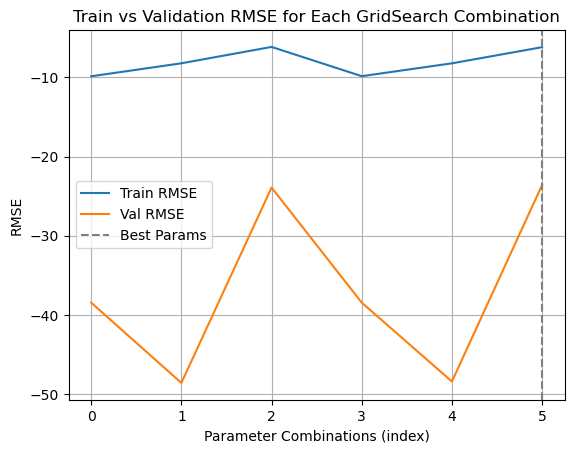

‚úÖ ÂΩìÂâç MLP Ê®°ÂûãÁöÑÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêà‰∏∫Ôºö {'alpha': 0.001, 'hidden_layer_sizes': (64, 64), 'learning_rate': 'constant'}

üìó ÊµãËØïÈõÜËØÑ‰º∞ÁªìÊûúÔºö
RMSE: 20.1268
MSE:  405.0879
MAE:  9.9496
R¬≤:   0.5959


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1Ô∏è‚É£ ÂÆö‰πâÊ®°Âûã
mlp = MLPRegressor(random_state=42, max_iter=1000)

# 2Ô∏è‚É£ ËÆæÁΩÆÂü∫Á°ÄÂèÇÊï∞ÊêúÁ¥¢ÁΩëÊ†ºÔºàËøêË°åÂø´„ÄÅÈÄÇÂêàÊ®°ÂûãÂØπÊØîÔºâ
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 64)],
    'alpha': [0.0001, 0.001],     # L2 Ê≠£ÂàôÈ°πÁ≥ªÊï∞
    'learning_rate': ['constant']  # Âõ∫ÂÆöÂ≠¶‰π†ÁéáÔºàÈªòËÆ§Ôºâ
}

# 3. GridSearchCV ËÆæÁΩÆ
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=10,
    scoring={
        'rmse': 'neg_root_mean_squared_error',
        'mae': 'neg_mean_absolute_error',
        'r2': 'r2'
    },
    refit='rmse',  # ‰ª• RMSE ÊúÄ‰ºòÊ®°Âûã‰Ωú‰∏∫ÊúÄÁªàÊ®°Âûã
    return_train_score=True,
    n_jobs=-1
)

# 4. Ê®°ÂûãËÆ≠ÁªÉ
grid_search.fit(X_selected_scaled, y_train)

# 5. Ëé∑Âèñ‰∫§ÂèâÈ™åËØÅÁªìÊûú
cv_results = grid_search.cv_results_
idx = grid_search.best_index_

train_rmse = -cv_results['mean_train_rmse'][idx]
val_rmse = -cv_results['mean_test_rmse'][idx]
gap_rmse = train_rmse - val_rmse
std_rmse = cv_results['std_test_rmse'][idx]

train_mae = -cv_results['mean_train_mae'][idx]
val_mae = -cv_results['mean_test_mae'][idx]
gap_mae = train_mae - val_mae
std_mae = cv_results['std_test_mae'][idx]

train_r2 = cv_results['mean_train_r2'][idx]
val_r2 = cv_results['mean_test_r2'][idx]
gap_r2 = train_r2 - val_r2
std_r2 = cv_results['std_test_r2'][idx]

# 6. ÊâìÂç∞ÊåáÊ†á
print(f"\nüìä GridSearchCV 10-Fold Âπ≥ÂùáÊåáÊ†áÔºàÊúÄ‰ºòÂèÇÊï∞ÁªÑÂêà idx={idx}ÔºâÔºö")
print(f"RMSE: Train={train_rmse:.4f} | Val={val_rmse:.4f} ¬± {std_rmse:.4f} | Gap={gap_rmse:.4f}")
print(f"MAE : Train={train_mae:.4f} | Val={val_mae:.4f} ¬± {std_mae:.4f} | Gap={gap_mae:.4f}")
print(f"R¬≤  : Train={train_r2:.4f} | Val={val_r2:.4f} ¬± {std_r2:.4f} | Gap={gap_r2:.4f}")

# 7. ÁªòÂõæ
plt.plot(cv_results['mean_train_rmse'], label='Train RMSE')
plt.plot(cv_results['mean_test_rmse'], label='Val RMSE')
plt.axvline(x=idx, color='gray', linestyle='--', label='Best Params')
plt.xlabel('Parameter Combinations (index)')
plt.ylabel('RMSE')
plt.title('Train vs Validation RMSE for Each GridSearch Combination')
plt.grid(True)
plt.legend()
plt.show()

# 8. Áî®ÊúÄ‰ºòÊ®°ÂûãËØÑ‰º∞ÊµãËØïÈõÜ
best_mlp = grid_search.best_estimator_
best_params = grid_search.best_params_
print("‚úÖ ÂΩìÂâç MLP Ê®°ÂûãÁöÑÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêà‰∏∫Ôºö", best_params)

# 7Ô∏è‚É£ ÊãüÂêàËÆ≠ÁªÉÈõÜ & È¢ÑÊµãÊµãËØïÈõÜ
best_mlp.fit(X_selected_scaled, y_train)
y_pred = best_mlp.predict(X_test_scaled)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("\nüìó ÊµãËØïÈõÜËØÑ‰º∞ÁªìÊûúÔºö")
print(f"RMSE: {test_rmse:.4f}")
print(f"MSE:  {test_mse:.4f}")
print(f"MAE:  {test_mae:.4f}")
print(f"R¬≤:   {test_r2:.4f}")



üìä GridSearchCV 10-Fold Âπ≥ÂùáÊåáÊ†áÔºàÊúÄ‰ºòÂèÇÊï∞ÁªÑÂêà idx=3ÔºâÔºö
RMSE: Train=18.2480 | Val=20.4391 ¬± 2.3496 | Gap=-2.1911
MAE : Train=10.6156 | Val=12.5708 ¬± 1.3731 | Gap=-1.9552
R¬≤  : Train=0.6946 | Val=0.6013 ¬± 0.0808 | Gap=0.0933


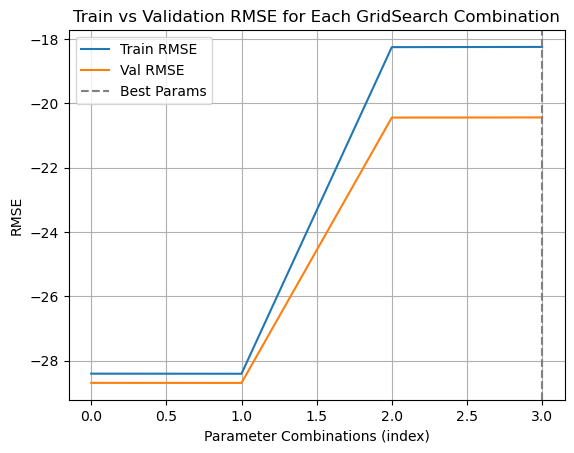

‚úÖ ÂΩìÂâç SVR Ê®°ÂûãÁöÑÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêà‰∏∫Ôºö {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'}

üìó ÊµãËØïÈõÜËØÑ‰º∞ÁªìÊûúÔºö
RMSE: 17.5539
MSE:  308.1410
MAE:  11.3015
R¬≤:   0.6926


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [13]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1Ô∏è‚É£ ÂÆö‰πâÊ®°Âûã
svr = SVR()

# 2Ô∏è‚É£ ËÆæÁΩÆÂü∫Á°ÄÂèÇÊï∞ÊêúÁ¥¢ËåÉÂõ¥
param_grid = {
    'C': [1, 10],             # Ê≠£ÂàôÂåñÂèÇÊï∞
    'epsilon': [0.1, 0.2],    # epsilon-tube ÁöÑÂÆΩÂ∫¶
    'kernel': ['rbf']         # Â∏∏Áî®Ê†∏ÂáΩÊï∞
}

grid_search = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    cv=10,
    scoring={
        'rmse': 'neg_root_mean_squared_error',
        'mae': 'neg_mean_absolute_error',
        'r2': 'r2'
    },
    refit='rmse',
    return_train_score=True,
    n_jobs=-1
)

# 4. Ê®°ÂûãËÆ≠ÁªÉ
grid_search.fit(X_selected_scaled, y_train)

# 5. Ëé∑Âèñ‰∫§ÂèâÈ™åËØÅÁªìÊûú
cv_results = grid_search.cv_results_
idx = grid_search.best_index_

train_rmse = -cv_results['mean_train_rmse'][idx]
val_rmse = -cv_results['mean_test_rmse'][idx]
gap_rmse = train_rmse - val_rmse
std_rmse = cv_results['std_test_rmse'][idx]

train_mae = -cv_results['mean_train_mae'][idx]
val_mae = -cv_results['mean_test_mae'][idx]
gap_mae = train_mae - val_mae
std_mae = cv_results['std_test_mae'][idx]

train_r2 = cv_results['mean_train_r2'][idx]
val_r2 = cv_results['mean_test_r2'][idx]
gap_r2 = train_r2 - val_r2
std_r2 = cv_results['std_test_r2'][idx]

# 6. ÊâìÂç∞ÊåáÊ†á
print(f"\nüìä GridSearchCV 10-Fold Âπ≥ÂùáÊåáÊ†áÔºàÊúÄ‰ºòÂèÇÊï∞ÁªÑÂêà idx={idx}ÔºâÔºö")
print(f"RMSE: Train={train_rmse:.4f} | Val={val_rmse:.4f} ¬± {std_rmse:.4f} | Gap={gap_rmse:.4f}")
print(f"MAE : Train={train_mae:.4f} | Val={val_mae:.4f} ¬± {std_mae:.4f} | Gap={gap_mae:.4f}")
print(f"R¬≤  : Train={train_r2:.4f} | Val={val_r2:.4f} ¬± {std_r2:.4f} | Gap={gap_r2:.4f}")

# 7. Â≠¶‰π†Êõ≤Á∫øÂèØËßÜÂåñ
plt.plot(cv_results['mean_train_rmse'], label='Train RMSE')
plt.plot(cv_results['mean_test_rmse'], label='Val RMSE')
plt.axvline(x=idx, color='gray', linestyle='--', label='Best Params')
plt.xlabel('Parameter Combinations (index)')
plt.ylabel('RMSE')
plt.title('Train vs Validation RMSE for Each GridSearch Combination')
plt.grid(True)
plt.legend()
plt.show()

# 8. Áî®ÊúÄ‰ºòÊ®°ÂûãËØÑ‰º∞ÊµãËØïÈõÜ
best_svr = grid_search.best_estimator_
best_params = grid_search.best_params_
print("‚úÖ ÂΩìÂâç SVR Ê®°ÂûãÁöÑÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêà‰∏∫Ôºö", best_params)

# 7Ô∏è‚É£ ËÆ≠ÁªÉÊúÄ‰ºòÊ®°ÂûãÂπ∂È¢ÑÊµãÊµãËØïÈõÜ
best_svr.fit(X_selected_scaled, y_train)
y_pred = best_svr.predict(X_test_scaled)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("\nüìó ÊµãËØïÈõÜËØÑ‰º∞ÁªìÊûúÔºö")
print(f"RMSE: {test_rmse:.4f}")
print(f"MSE:  {test_mse:.4f}")
print(f"MAE:  {test_mae:.4f}")
print(f"R¬≤:   {test_r2:.4f}")



üìä GridSearchCV 10-Fold Âπ≥ÂùáÊåáÊ†áÔºàÊúÄ‰ºòÂèÇÊï∞ÁªÑÂêà idx=849ÔºâÔºö
RMSE: Train=5.2793 | Val=12.1336 ¬± 1.7825 | Gap=-6.8543
MAE : Train=3.2436 | Val=7.2834 ¬± 1.0028 | Gap=-4.0397
R¬≤  : Train=0.9744 | Val=0.8578 ¬± 0.0449 | Gap=0.1166


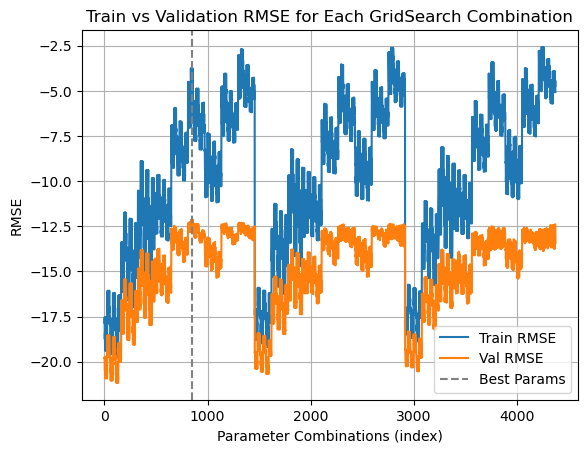

‚úÖ ÂΩìÂâç XGBoost Ê®°ÂûãÁöÑÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêà‰∏∫Ôºö {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 400, 'reg_alpha': 0.1, 'reg_lambda': 5, 'subsample': 0.6}

üìó ÊµãËØïÈõÜËØÑ‰º∞ÁªìÊûúÔºö
RMSE: 11.9280
MSE:  142.2781
MAE:  7.2543
R¬≤:   0.8581


In [14]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1Ô∏è‚É£ ÂÆö‰πâÊ®°Âûã
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    verbosity=0
)

# 2Ô∏è‚É£ ËÆæÁΩÆÂü∫Á°ÄÂèÇÊï∞ÊêúÁ¥¢ËåÉÂõ¥
param_grid = {
    'n_estimators': [300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10],
    'min_child_weight': [1, 3, 5]
}


# 3. ËÆæÁΩÆ GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=10,
    scoring={
        'rmse': 'neg_root_mean_squared_error',
        'mae': 'neg_mean_absolute_error',
        'r2': 'r2'
    },
    refit='rmse',
    return_train_score=True,
    n_jobs=-1
)

# 4. Ê®°ÂûãËÆ≠ÁªÉ
grid_search.fit(X_selected_scaled, y_train)

# 5. Ëé∑Âèñ‰∫§ÂèâÈ™åËØÅÁªìÊûú
cv_results = grid_search.cv_results_
idx = grid_search.best_index_

train_rmse = -cv_results['mean_train_rmse'][idx]
val_rmse = -cv_results['mean_test_rmse'][idx]
gap_rmse = train_rmse - val_rmse
std_rmse = cv_results['std_test_rmse'][idx]

train_mae = -cv_results['mean_train_mae'][idx]
val_mae = -cv_results['mean_test_mae'][idx]
gap_mae = train_mae - val_mae
std_mae = cv_results['std_test_mae'][idx]

train_r2 = cv_results['mean_train_r2'][idx]
val_r2 = cv_results['mean_test_r2'][idx]
gap_r2 = train_r2 - val_r2
std_r2 = cv_results['std_test_r2'][idx]

# 6. ÊâìÂç∞ÊåáÊ†á
print(f"\nüìä GridSearchCV 10-Fold Âπ≥ÂùáÊåáÊ†áÔºàÊúÄ‰ºòÂèÇÊï∞ÁªÑÂêà idx={idx}ÔºâÔºö")
print(f"RMSE: Train={train_rmse:.4f} | Val={val_rmse:.4f} ¬± {std_rmse:.4f} | Gap={gap_rmse:.4f}")
print(f"MAE : Train={train_mae:.4f} | Val={val_mae:.4f} ¬± {std_mae:.4f} | Gap={gap_mae:.4f}")
print(f"R¬≤  : Train={train_r2:.4f} | Val={val_r2:.4f} ¬± {std_r2:.4f} | Gap={gap_r2:.4f}")

# 7. Â≠¶‰π†Êõ≤Á∫øÂèØËßÜÂåñ
plt.plot(cv_results['mean_train_rmse'], label='Train RMSE')
plt.plot(cv_results['mean_test_rmse'], label='Val RMSE')
plt.axvline(x=idx, color='gray', linestyle='--', label='Best Params')
plt.xlabel('Parameter Combinations (index)')
plt.ylabel('RMSE')
plt.title('Train vs Validation RMSE for Each GridSearch Combination')
plt.grid(True)
plt.legend()
plt.show()


# 8. Áî®ÊúÄ‰ºòÊ®°ÂûãËØÑ‰º∞ÊµãËØïÈõÜ
best_xgb = grid_search.best_estimator_
best_params = grid_search.best_params_
print("‚úÖ ÂΩìÂâç XGBoost Ê®°ÂûãÁöÑÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêà‰∏∫Ôºö", best_params)

# 7Ô∏è‚É£ ÊúÄÁªàÊãüÂêà & ÊµãËØïÈõÜÈ¢ÑÊµã
best_xgb.fit(X_selected_scaled, y_train)
y_pred = best_xgb.predict(X_test_scaled)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("\nüìó ÊµãËØïÈõÜËØÑ‰º∞ÁªìÊûúÔºö")
print(f"RMSE: {test_rmse:.4f}")
print(f"MSE:  {test_mse:.4f}")
print(f"MAE:  {test_mae:.4f}")
print(f"R¬≤:   {test_r2:.4f}")



üìä GridSearchCV 10-Fold Âπ≥ÂùáÊåáÊ†áÔºàÊúÄ‰ºòÂèÇÊï∞ÁªÑÂêà idx=83ÔºâÔºö
RMSE: Train=5.9803 | Val=12.4658 ¬± 1.8742 | Gap=-6.4856
MAE : Train=3.9429 | Val=7.7146 ¬± 1.0052 | Gap=-3.7717
R¬≤  : Train=0.9672 | Val=0.8504 ¬± 0.0451 | Gap=0.1168


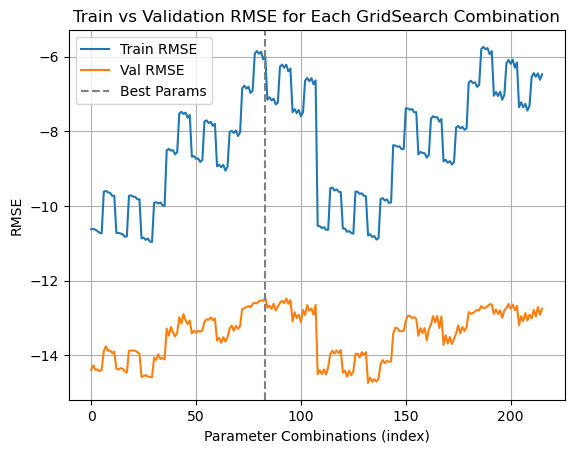

In [15]:
# 1Ô∏è‚É£ ÂÆö‰πâÊ®°Âûã
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    verbosity=0
)

# 2Ô∏è‚É£ ËÆæÁΩÆÂü∫Á°ÄÂèÇÊï∞ÊêúÁ¥¢ËåÉÂõ¥
param_grid = {
    'learning_rate': [0.05],
    'max_depth': [3, 4, 5],
    'reg_alpha': [2, 5, 10],
    'min_child_weight': [1, 2, 3],
    'colsample_bytree': [0.7, 0.8],
    'subsample': [0.7, 0.8],
    'n_estimators': [300, 400]
}



# 3. ËÆæÁΩÆ GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=10,
    scoring={
        'rmse': 'neg_root_mean_squared_error',
        'mae': 'neg_mean_absolute_error',
        'r2': 'r2'
    },
    refit='rmse',
    return_train_score=True,
    n_jobs=-1
)

# 4. Ê®°ÂûãËÆ≠ÁªÉ
grid_search.fit(X_selected_scaled, y_train)

# 5. Ëé∑Âèñ‰∫§ÂèâÈ™åËØÅÁªìÊûú
cv_results = grid_search.cv_results_
idx = grid_search.best_index_

train_rmse = -cv_results['mean_train_rmse'][idx]
val_rmse = -cv_results['mean_test_rmse'][idx]
gap_rmse = train_rmse - val_rmse
std_rmse = cv_results['std_test_rmse'][idx]

train_mae = -cv_results['mean_train_mae'][idx]
val_mae = -cv_results['mean_test_mae'][idx]
gap_mae = train_mae - val_mae
std_mae = cv_results['std_test_mae'][idx]

train_r2 = cv_results['mean_train_r2'][idx]
val_r2 = cv_results['mean_test_r2'][idx]
gap_r2 = train_r2 - val_r2
std_r2 = cv_results['std_test_r2'][idx]

# 6. ÊâìÂç∞ÊåáÊ†á
print(f"\nüìä GridSearchCV 10-Fold Âπ≥ÂùáÊåáÊ†áÔºàÊúÄ‰ºòÂèÇÊï∞ÁªÑÂêà idx={idx}ÔºâÔºö")
print(f"RMSE: Train={train_rmse:.4f} | Val={val_rmse:.4f} ¬± {std_rmse:.4f} | Gap={gap_rmse:.4f}")
print(f"MAE : Train={train_mae:.4f} | Val={val_mae:.4f} ¬± {std_mae:.4f} | Gap={gap_mae:.4f}")
print(f"R¬≤  : Train={train_r2:.4f} | Val={val_r2:.4f} ¬± {std_r2:.4f} | Gap={gap_r2:.4f}")

# 7. Â≠¶‰π†Êõ≤Á∫øÂèØËßÜÂåñ
plt.plot(cv_results['mean_train_rmse'], label='Train RMSE')
plt.plot(cv_results['mean_test_rmse'], label='Val RMSE')
plt.axvline(x=idx, color='gray', linestyle='--', label='Best Params')
plt.xlabel('Parameter Combinations (index)')
plt.ylabel('RMSE')
plt.title('Train vs Validation RMSE for Each GridSearch Combination')
plt.grid(True)
plt.legend()
plt.show()

In [16]:
# ÊâìÂç∞ÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêà
print("‚úÖ ÂΩìÂâç XGBoost Ê®°ÂûãÁöÑÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêà‰∏∫Ôºö", grid_search.best_params_)


‚úÖ ÂΩìÂâç XGBoost Ê®°ÂûãÁöÑÊúÄ‰Ω≥ÂèÇÊï∞ÁªÑÂêà‰∏∫Ôºö {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 400, 'reg_alpha': 10, 'subsample': 0.8}
